In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, model_from_json
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from numpy.random import randn

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def plot(autoencoder, encoder, x, save):
    encoded_imgs = encoder.predict(X_test_noisy)
    predicted = autoencoder.predict(X_test_noisy)
    plt.figure(figsize=(40, 4))
    for i in range(20):    
        ax = plt.subplot(4, 20, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, 20, i + 1+20)
        plt.imshow(X_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, 20, 2*20+i + 1 )
        plt.imshow(encoded_imgs[i].reshape(32,8))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, 20, 3*20 +i+ 1)
        plt.imshow(predicted[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if save:
        plt.savefig("plots/plot_{0}.png".format(x))
        plt.close()
    else:
        plt.show()

In [4]:
def load(x):
    json_file = open('autoencoder/model_autoencoder_{0}.json'.format(x), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    autoencoder = model_from_json(loaded_model_json)
    autoencoder.load_weights("autoencoder/model_autoencoder_{0}.h5".format(x))
    json_file = open('encoder/model_encoder_{0}.json'.format(x), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    encoder = model_from_json(loaded_model_json)
    encoder.load_weights("encoder/model_encoder_{0}.h5".format(x))
    return autoencoder, encoder

In [5]:
def save(autoencoder, encoder, x):
    model_json = autoencoder.to_json()
    with open("autoencoder/model_autoencoder_{0}.json".format(x), "w") as json_file:
        json_file.write(model_json)
    autoencoder.save_weights("autoencoder/model_autoencoder_{0}.h5".format(x))
    model_json = encoder.to_json()
    with open("encoder/model_encoder_{0}.json".format(x), "w") as json_file:
        json_file.write(model_json)
    encoder.save_weights("encoder/model_encoder_{0}.h5".format(x))

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    z_input = []
    for x in range(n_samples):
        z_input += [randn(latent_dim).reshape(28, 28, 1)]
    return np.asarray(z_input)

In [6]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
X_test = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))
X_train_noisy = X_train + np.random.normal(loc=0.0, scale=0.1, size=X_train.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = X_test + np.random.normal(loc=0.0, scale=0.1, size=X_test.shape)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)
X_train_noisy = np.reshape(X_train_noisy, (len(X_train_noisy), 28, 28, 1))
X_test_noisy = np.reshape(X_test_noisy, (len(X_test_noisy), 28, 28, 1))

In [7]:
autoencoder, encoder = load(49)

In [8]:
input_img = Input(shape=(28, 28, 1))

In [ ]:
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [ ]:
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [ ]:
autoencoder = Model(input_img, decoded)

In [ ]:
encoder = Model(input_img, encoded)

In [9]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
for x in range(50, 60):
    autoencoder.fit(X_train_noisy, X_train_noisy,
                    epochs=50,
                    batch_size=16,
                    shuffle=True,
                    validation_data=(X_test_noisy, X_test_noisy))
    save(autoencoder, encoder, x)    
    plot(autoencoder, encoder, x, 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 21s 346us/sample - loss: 0.2241 - accuracy: 0.4492 - val_loss: 0.2235 - val_accuracy: 0.4495
Epoch 2/50
60000/60000 [==============================] - 16s 266us/sample - loss: 0.2241 - accuracy: 0.4492 - val_loss: 0.2235 - val_accuracy: 0.4495
Epoch 3/50
60000/60000 [==============================] - 15s 254us/sample - loss: 0.2241 - accuracy: 0.4492 - val_loss: 0.2235 - val_accuracy: 0.4495
Epoch 4/50
60000/60000 [==============================] - 16s 260us/sample - loss: 0.2241 - accuracy: 0.4492 - val_loss: 0.2235 - val_accuracy: 0.4495
Epoch 5/50
60000/60000 [==============================] - 15s 254us/sample - loss: 0.2241 - accuracy: 0.4492 - val_loss: 0.2235 - val_accuracy: 0.4495
Epoch 6/50
60000/60000 [==============================] - 15s 252us/sample - loss: 0.2241 - accuracy: 0.4492 - val_loss: 0.2235 - val_accuracy: 0.4495
Epoch 7/50
60000/60000 [====================

60000/60000 [==============================] - 15s 257us/sample - loss: 0.2240 - accuracy: 0.4492 - val_loss: 0.2233 - val_accuracy: 0.4495
Epoch 5/50
60000/60000 [==============================] - 16s 259us/sample - loss: 0.2240 - accuracy: 0.4492 - val_loss: 0.2233 - val_accuracy: 0.4495
Epoch 6/50
60000/60000 [==============================] - 15s 254us/sample - loss: 0.2240 - accuracy: 0.4492 - val_loss: 0.2233 - val_accuracy: 0.4495
Epoch 7/50
60000/60000 [==============================] - 16s 260us/sample - loss: 0.2240 - accuracy: 0.4492 - val_loss: 0.2233 - val_accuracy: 0.4495
Epoch 8/50
60000/60000 [==============================] - 15s 257us/sample - loss: 0.2240 - accuracy: 0.4492 - val_loss: 0.2233 - val_accuracy: 0.4495
Epoch 9/50
60000/60000 [==============================] - 15s 257us/sample - loss: 0.2240 - accuracy: 0.4492 - val_loss: 0.2233 - val_accuracy: 0.4495
Epoch 10/50
60000/60000 [==============================] - 15s 255us/sample - loss: 0.2240 - accuracy: 0.

Epoch 8/50
60000/60000 [==============================] - 16s 262us/sample - loss: 0.2238 - accuracy: 0.4492 - val_loss: 0.2232 - val_accuracy: 0.4495
Epoch 9/50
60000/60000 [==============================] - 17s 276us/sample - loss: 0.2238 - accuracy: 0.4493 - val_loss: 0.2232 - val_accuracy: 0.4495
Epoch 10/50
60000/60000 [==============================] - 18s 304us/sample - loss: 0.2238 - accuracy: 0.4493 - val_loss: 0.2232 - val_accuracy: 0.4495
Epoch 11/50
60000/60000 [==============================] - 17s 275us/sample - loss: 0.2238 - accuracy: 0.4493 - val_loss: 0.2232 - val_accuracy: 0.4495
Epoch 12/50
60000/60000 [==============================] - 16s 271us/sample - loss: 0.2238 - accuracy: 0.4493 - val_loss: 0.2232 - val_accuracy: 0.4495
Epoch 13/50
60000/60000 [==============================] - 17s 288us/sample - loss: 0.2238 - accuracy: 0.4493 - val_loss: 0.2232 - val_accuracy: 0.4495
Epoch 14/50
60000/60000 [==============================] - 16s 270us/sample - loss: 0.2238

60000/60000 [==============================] - 16s 266us/sample - loss: 0.2237 - accuracy: 0.4493 - val_loss: 0.2231 - val_accuracy: 0.4495
Epoch 12/50
60000/60000 [==============================] - 19s 318us/sample - loss: 0.2237 - accuracy: 0.4493 - val_loss: 0.2231 - val_accuracy: 0.4495
Epoch 13/50
60000/60000 [==============================] - 16s 268us/sample - loss: 0.2237 - accuracy: 0.4493 - val_loss: 0.2231 - val_accuracy: 0.4495
Epoch 14/50
60000/60000 [==============================] - 18s 302us/sample - loss: 0.2237 - accuracy: 0.4493 - val_loss: 0.2231 - val_accuracy: 0.4495
Epoch 15/50
60000/60000 [==============================] - 17s 289us/sample - loss: 0.2237 - accuracy: 0.4493 - val_loss: 0.2231 - val_accuracy: 0.4495
Epoch 16/50
60000/60000 [==============================] - 16s 262us/sample - loss: 0.2237 - accuracy: 0.4493 - val_loss: 0.2231 - val_accuracy: 0.4495
Epoch 17/50
60000/60000 [==============================] - 18s 307us/sample - loss: 0.2237 - accurac

KeyboardInterrupt: 

# Distance

In [ ]:
# for layer in autoencoder.layers: print(layer.get_config(), layer.get_weights())

In [ ]:
# layer_weights = autoencoder.layers[4].get_weights()[0]

In [ ]:
# layer_weights.shape

In [ ]:
# encoded_imgs[2].shape

In [ ]:
# autoencoder.summary()

In [ ]:
# for layer in encoder.layers: print(layer.get_config(), layer.get_weights())

In [ ]:
# layer_weights = encoder.layers[5].get_weights()[0]

In [ ]:
# layer_weights.shape

In [ ]:
# plot(autoencoder, encoder, 1, 0)

In [12]:
from matplotlib.image import imread

img = imread('seven.jpg')
print(type(img))

FileNotFoundError: [Errno 2] No such file or directory: 'seven.jpg'

In [ ]:
img = np.asarray(img)

In [ ]:
img.shape

In [ ]:
plt.imshow(img)

In [ ]:
from skimage import color
from skimage import io



In [ ]:
imgs = []

In [ ]:
imgs += (np.asarray(color.rgb2gray(io.imread('seven.jpg'))).astype('float64')/255).reshape(28, 28, 1)

In [ ]:
prediction = autoencoder.predict(imgs)

In [ ]:
P = prediction[0].reshape(28, 28)

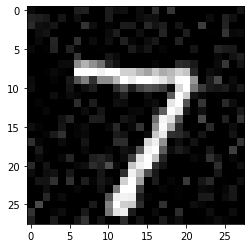

In [13]:
plt.imshow(X_test_noisy[0].reshape(28, 28))

In [14]:
plt.imshow(imgs[0])

NameError: name 'imgs' is not defined